In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# SIMS 

In [ ]:
# block rewards + MEV rewards 
# selfish, beta-execution, beta-both

In [ ]:
# SELFISH
def simSelfish(alpha, gamma=0, total=int(1e3)):
    curState = 0
    selfishBlocks = 0
    otherBlocks = 0
    for _ in range(total):
        flip = np.random.uniform()
        if curState == 0:
            if flip < alpha:
                curState = 1
            else: otherBlocks += 1
#         elif curState == 'double':
#             if flip < alpha:
#                 selfishBlocks += 1
#             else: otherBlocks += 1
#             curState = 0
        elif curState == 'single':
            if flip < alpha:
                selfishBlocks += 2
            elif flip < alpha + gamma * (1-alpha):
                selfishBlocks += 1
                otherBlocks += 1
            else:
                otherBlocks += 2
            curState = 0
        elif curState == 1:
            if flip < alpha:
                curState = 2
            else: curState = 'single'
        elif curState == 2:
            if flip < alpha:
                selfishBlocks += 1
                curState = 3
            else:
                selfishBlocks += 2
#                 curState = 'double'
                curState = 0
        else:
            if flip < alpha:
                selfishBlocks += 1
                curState += 1
            else:
                curState -= 1
    if curState not in [0, 'single', 'double']:
        selfishBlocks += curState
    return selfishBlocks/(selfishBlocks+otherBlocks)

In [278]:
# SELFISH EXEC
def simSelfishExecution(alpha, gamma=0, total=int(1e3)):
    curState    = 0
    curBalance  = 0
    selfishRews = 0
    otherRews   = 0
    curBalState = []
    for i in range(total):
        flip   = np.random.uniform()
        amount = np.random.exponential()
        if curState == 0:
            if flip < alpha:
                curState = 1
                curBalance += amount
                curBalState.append(0)
            else: otherRews += amount
        elif curState == 1:
            if flip < alpha:
                curBalance += amount
                selfishRews += curBalance
                curState = 2
                curBalance = 0
                curBalState = []
            else: 
                curState = 'single'
                curBalance += amount
                curBalState.append(1)
        elif curState == 'double':
            curBalance += amount
            if flip < alpha:
                selfishRews += curBalance
            else: otherRews += curBalance
            curState = 0
            curBalance = 0
            curBalState = []
        elif curState == 'single':
            if flip < alpha:
                curBalance += amount
                selfishRews += curBalance
            elif flip < alpha + gamma * (1-alpha):
                selfishRews += curBalance
                otherRews += amount
            else:
                curBalance += amount
                otherRews += curBalance
            curState = 0
            curBalance = 0
            curBalState = []
        elif curState == 2:
            if flip < alpha:
                selfishRews += amount
                curState = 3
            else:
                curBalance += amount
                curBalState.append(2)
                curState = 'double'
        else:
            if flip < alpha:
                selfishRews += amount
                curState += 1
            else:
                curBalance += amount
                curBalState.append(curState)
                curState -= 1
#     if curState not in [0, 'single', 'double']:
#         selfishRews += curBalance

    return selfishRews/(selfishRews+otherRews)

In [ ]:
simSelfishExecution(0.3, gamma=0, total=10)

In [288]:
n = 100
alpha, gamma = 0.3, 0.0
slots = np.zeros(n)
slotRews = np.zeros(n)
lastAttSlot = 0
curState    = 0
flips = [0, 0, 0, 1, 1, 1]
for i in range(n):
    print('slots: {}'.format(slots[:i]))
    print(' - state: {}'.format(curState ))
    flip = flips[i]
#     flip   = np.random.uniform()
    amount = np.random.exponential()
    slotRews[i] = amount
    if curState == 0:
        if flip < alpha:
            curState = 1
        else:
            slots[i] -= 1
    elif curState == 1:
        if flip < alpha:
            slots[i-1:i+1] += 1
            curState = 2
            lastAttSlot = i
        else: 
            curState = 'single'
    elif curState == 'double':
        if flip < alpha:
            slots[lastAttSlot+1:i+1] += 1
        else:
            slots[lastAttSlot+1:i+1] -= 1
        lastAttSlot = i
        curState = 0
    elif curState == 'single':
        if flip < alpha:
            slots[i-2:i+1] += 1
        elif flip < alpha + gamma * (1-alpha):
            slots[i-2:i] += 1
            slots[i] -= 1
        else:
            slots[i-2:i+1] -= 1
        lastAttSlot = i
        curState = 0
    elif curState == 2:
        if flip < alpha:
            slots[lastAttSlot+1:i+1] += 1
            curState = 3
            lastAttSlot = i
        else:
            curState = 'double'
    else:
        if flip < alpha:
            slots[lastAttSlot+1:i+1] += 1
            lastAttSlot = i
            curState += 1
        else:
            curState -= 1
slots, slotRews

slots: []
 - state: 0
slots: [0.]
 - state: 1
slots: [1. 1.]
 - state: 2
slots: [1. 1. 1.]
 - state: 3
slots: [1. 1. 1. 0.]
 - state: 2
slots: [1. 1. 1. 0. 0.]
 - state: double
slots: [ 1.  1.  1. -1. -1. -1.]
 - state: 0


IndexError: list index out of range

In [269]:
def simSelfishBounds(alpha, gamma=0, total=int(1e3)):
    n = total
    slots = np.zeros(n)
    slotRews = np.zeros(n)
    lastAttSlot = 0
    curState    = 0
    for i in range(n):
        flip   = np.random.uniform()
        amount = np.random.exponential()
        slotRews[i] = amount
        if curState == 0:
            if flip < alpha:
                curState = 1
            else:
                slots[i] -= 1
        elif curState == 1:
            if flip < alpha:
                slots[i-1:i+1] += 1
                curState = 2
                lastAttSlot = i
            else: 
                curState = 'single'
        elif curState == 'double':
            if flip < alpha:
                slots[lastAttSlot+1:i+1] += 1
            else:
                slots[lastAttSlot+1:i+1] -= 1
            lastAttSlot = i
            curState = 0
        elif curState == 'single':
            if flip < alpha:
                slots[i-2:i+1] += 1
            elif flip < alpha + gamma * (1-alpha):
                slots[i-2:i] += 1
                slots[i] -= 1
            else:
                slots[i-2:i+1] -= 1
            lastAttSlot = i
            curState = 0
        elif curState == 2:
            if flip < alpha:
                slots[lastAttSlot+1:i+1] += 1
                curState = 3
                lastAttSlot = i
            else:
                curState = 'double'
        else:
            if flip < alpha:
                slots[lastAttSlot+1:i+1] += 1
                lastAttSlot = i
                curState += 1
            else:
                curState -= 1
    return sum(slotRews[slots == 1]) / sum(slotRews)

In [279]:
def selfishRewardEyal(a, gamma):
    num = a * np.power(1-a, 2) * (4*a + gamma*(1-2*a)) - np.power(a,3)
    den = 1 - a * (1 + (2-a)*a)
    return num/den

def selfishRewardCarlsten(a, gamma):
    num = 5*a**2 - 12*a**3 + 9*a**4 - 2*a**5 + gamma * (a - 4*a**2 + 6*a**3 - 5*a**4 + 2*a**5)
    den = 2*a**3 - 4*a**2 + 1
    return num / den

def selfishRewardSim(a, gamma, count=int(1e4)):
    res = []
    for _ in range(10):
        res.append(simSelfish(a, gamma, total=count))
    return np.mean(res)

def selfishRewardExecSim(a, gamma, count=int(2e4)):
    res = []
    for _ in range(10):
        res.append(simSelfishBounds(a, gamma, total=count))
    return np.mean(res)

def selfishRewardExecSim2(a, gamma, count=int(2e4)):
    res = []
    for _ in range(10):
        res.append(simSelfishExecution(a, gamma, total=count))
    return np.mean(res)

In [280]:
alphas = np.arange(0.001, 0.50, 0.001)
wRes, eRes = [], []
for g in [0, 0.5, 1]:
    wRes.append(selfishRewardCarlsten(alphas, g))
    eRes.append(selfishRewardEyal(alphas, g))
wRes = np.array(wRes)
eRes = np.array(eRes)

simRes     = []
simResExec = []
simAlphas  = np.arange(0.01, 0.5, 0.05)
for g in [0, 0.5, 1]:
    temp, tempExec = [], []
    for alpha in tqdm(simAlphas):
#         temp.append(selfishRewardSim(alpha, g))
        tempExec.append(selfishRewardExecSim(alpha, g))
        temp.append(selfishRewardExecSim2(alpha, g))
    simRes.append(temp)
    simResExec.append(tempExec)
simRes = np.array(simRes)
simResExec = np.array(simResExec)

wRes.shape, eRes.shape, simRes.shape, simResExec.shape

100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


((3, 499), (3, 499), (3, 10), (3, 10))

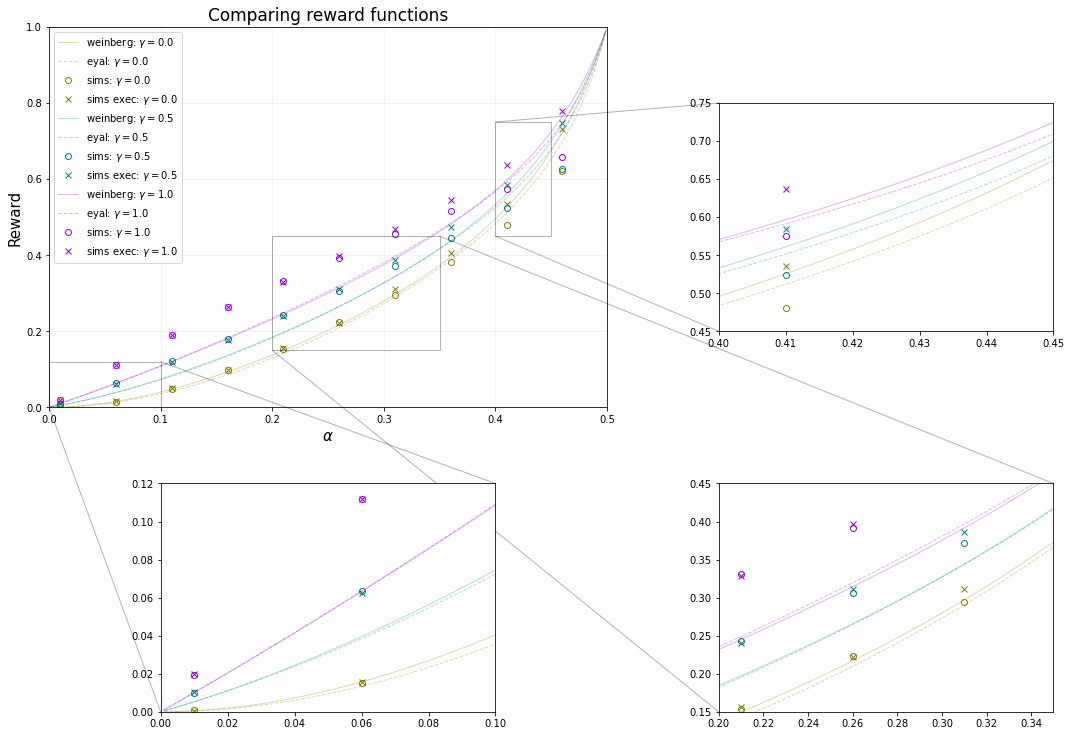

In [281]:
f, ax = plt.subplots(figsize=(10,7))

axins0 = ax.inset_axes([0.2, -0.8, 0.6, 0.6], xlim=(0., 0.1), ylim=(0., .12))
axins1 = ax.inset_axes([1.2, 0.2, 0.6, 0.6], xlim=(0.4, 0.45), ylim=(0.45, 0.75))
axins2 = ax.inset_axes([1.2, -0.8, 0.6, 0.6], xlim=(0.2, 0.35), ylim=(0.15, 0.45))
ax.indicate_inset_zoom(axins0, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins1, edgecolor="black", label=None, alpha=0.3)
ax.indicate_inset_zoom(axins2, edgecolor="black", label=None, alpha=0.3)


colors = ['olive', 'teal', 'darkviolet']
for i, g in enumerate([0, 0.5, 1]):
    for a in [ax, axins0, axins1, axins2]:
        a.plot(alphas, wRes[i], linewidth=1, color=colors[i], label=r'weinberg: $\gamma={:0.1f}$'.format(g),
               alpha=0.3)
        a.plot(alphas, eRes[i], linewidth=1, color=colors[i], label=r'eyal: $\gamma={:0.1f}$'.format(g),
                linestyle='--', alpha=0.3)
        a.plot(simAlphas, simRes[i], marker='o', fillstyle='none', linewidth=0, 
                label='sims: $\gamma={:0.1f}$'.format(g), color=colors[i])
        a.plot(simAlphas, simResExec[i], marker='x', fillstyle='none', linewidth=0, 
                label='sims exec: $\gamma={:0.1f}$'.format(g), color=colors[i])
        
ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Reward', size=15)
ax.set_title(r'Comparing reward functions', size=17)

ax.set_xlim(0,0.5)
ax.set_ylim(0,1)
ax.grid(alpha=0.2)
ax.legend(loc=2)
# plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

# FIG 10 w/ sims

In [ ]:
def weinRews(alpha, gamma, beta):
    num1 = 1 + (beta * np.power(1-alpha,2) * (1-gamma))
    den1 = np.exp(beta) - 1
    exp1 = num1 / den1
    exp2 = exp1 + (5 * alpha) + (np.power(1-alpha, 2) * gamma) 
    exp3 = (2 * np.power(alpha, 2)) / (1-2 * alpha) - (2 * np.power(alpha,2))
    exp4 = exp2 + exp3
    num2 = alpha * (1-2*alpha) * (1 - np.exp(-beta))
    den2 = 1 - 2 * np.exp(-beta) * alpha - 3 * (1 - np.exp(-beta)) * np.power(alpha,2)
    exp5 = num2 / den2
    return exp4 * exp5

In [ ]:
flip = np.random.uniform()
flip

# p1 calculation

In [ ]:
a, b, d, p1 = sp.symbols('alpha beta delta p_1')

p0   = p1/(a*(1-1/b**d))
p0p  = (1-a)*p1
p0dp = a*p1
p2p  = p1*(1-a)*a/((a-1)*(2*a-1))

eq = sp.Eq(p0 + p0p + p0dp + p1 + p2p, 1)
sol = sp.solve(eq, p1)

In [ ]:
p0

In [ ]:
sol[0]

In [ ]:
p1 = sol[0].evalf(subs={d:2})
p1

# f0p0

In [ ]:
x, d, b = sp.symbols('x delta beta')
sp.integrate(1/x**2, (x, b, sp.oo))
# sp.integrate(1/x**d, (x))

In [ ]:
x, d, b, a, g = sp.symbols('x delta beta alpha gamma')

expr = (1/x**d) * ((1/(b+x)**d) + a**2*(1-1/(b+x)**d) + a*(1-a)*(a+(1-a)*g)*(1-1/(b+x)**d))
sp.expand(expr)

In [ ]:
expanded = sp.expand(expr).evalf(subs={d:3})
expanded

In [ ]:
out = sp.integrate(expanded, (x, 0, b))
out

In [ ]:
print_latex(sp.simplify(out))

In [ ]:
total = sp.simplify((out + 2*a**2/(1-2*a)+3*a-a**2)*p1)
total

In [ ]:
total

In [ ]:
# R_f general
a, b, g = sp.symbols('alpha beta gamma')

A_expr = a * (sp.exp(-b) / (a*(1-sp.exp(-b))) + 2 - a + ((2-a)/(1-a)) + ((((1-a)**2)*g)/a) + (a**2/((1-2*a)*(1-a))))
H_expr = (1-a) / (a*(1-sp.exp(-b))) + ((1-a)**2)*(2-g) + a*(1-a)

R_f = A_expr / (A_expr + H_expr)

simplified_Rf = sp.simplify(R_f)
simplified_Rf